# Plot Lyapunov exponents and Eigenvalues for Active Filament simulations

In [15]:
import sys
if 'init_modules' in globals().keys():
    # second or subsequent run: remove all but initially loaded modules
    for m in sys.modules.keys():
        if m not in init_modules:
            del(sys.modules[m])
else:
    # first run: find out which modules were initially loaded
    init_modules = sys.modules.keys()
import numpy as np
from scipy import signal
from scipy import interpolate
import matplotlib.pyplot as plt 
import seaborn as sns
import os
import pyfilaments.analysisutils as analysis
from pyfilaments._def_analysis import *
import pandas as pd
import h5py

from joblib import Parallel, delayed
import multiprocessing
%matplotlib notebook
plt.close('all')
# Create a folder for storing Publication figures
publication_figures = '/home/deepak/Dropbox/LacryModeling/ActiveFilamentsManuscript/Figures/Figure3'

import _figure_parameters

# No:of Significant Eigenvalues Plot

In [15]:
batch_analysis_folder = '/home/deepak/ActiveFilamentsSearch_backup_3/ActivityStrengthSweep_widerICS_FINAL_2021-12-23'

parameter = 'potDipole strength'


df_sig_eigenvalues = pd.DataFrame({})

for root, dirs, files in os.walk(batch_analysis_folder):
    
    for file in files:
        
        if('eigenvectors' in file and file.endswith('.hdf5')):
            
            with h5py.File(os.path.join(root, file), "r") as f:

                dset = f['eigenvectors']

                eigenvalues_sig = dset['eigenvalues'][:]
                eigenvectors_sig = dset['eigenvectors'][:]

                n_sig_eigenvalues = len(eigenvalues_sig)
                
                # Load metadata
                base_folder, *rest = os.path.split(root)
                
                df_metadata = pd.read_csv(os.path.join(base_folder, 'metadata.csv'))
                
                parameter_value = df_metadata[parameter][0]
                
                df_sig_eigenvalues = df_sig_eigenvalues.append(pd.DataFrame({parameter:[parameter_value], 'N sig eigenvalues':[n_sig_eigenvalues]}))
    

In [16]:
df_sig_eigenvalues

,potDipole strength,N sig eigenvalues
0,0.692308,3
0,1.076923,3
0,0.564103,1
0,0.948718,3
0,1.974359,4
0,1.461538,3
0,0.500000,1
0,1.717949,3
0,1.782051,3
0,1.589744,3


<IPython.core.display.Javascript object>


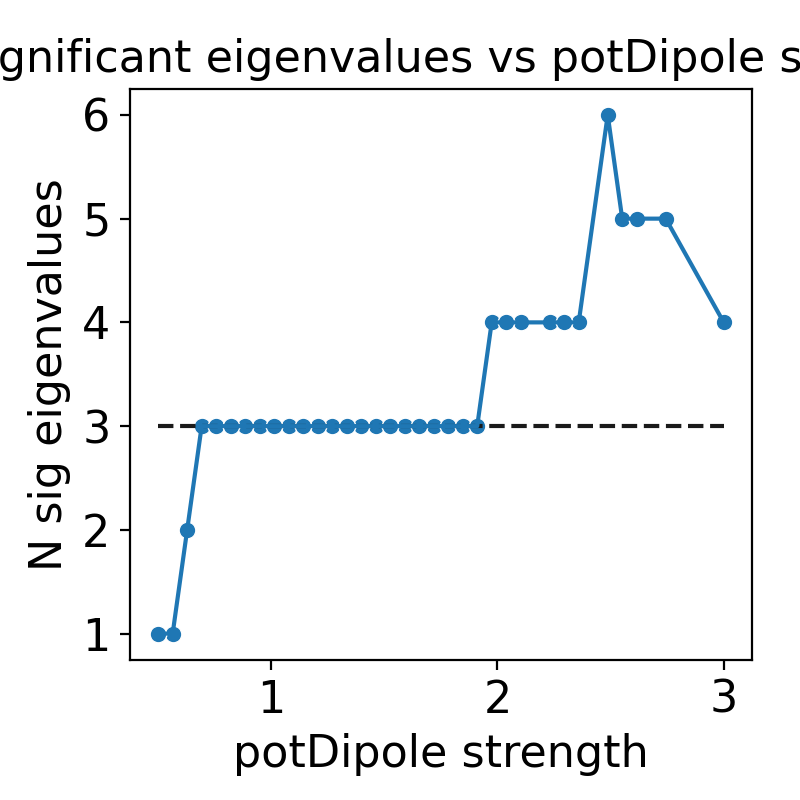

In [36]:
# Plot No:of sign eigenvalues vs parameter of interest
# plt.style.use('default')

title = 'N significant eigenvalues vs {}'.format(parameter)
plt.figure(figsize=(4,4))
sns.scatterplot(data = df_sig_eigenvalues, x = parameter, y = 'N sig eigenvalues', palette = 'dark')
sns.lineplot(data = df_sig_eigenvalues, x = parameter, y = 'N sig eigenvalues', markers = True, palette = 'dark')
plt.hlines(y=3, xmin=min(df_sig_eigenvalues[parameter]),xmax=max(df_sig_eigenvalues[parameter]), linestyle = '--', color = 'k')
plt.title(title)


plt.savefig(os.path.join(publication_figures, title+'.png'), dpi = 300)
plt.savefig(os.path.join(publication_figures, title+'.svg'), dpi = 300)
plt.tight_layout()
plt.show()

# Lyapunov exponent plot

<IPython.core.display.Javascript object>


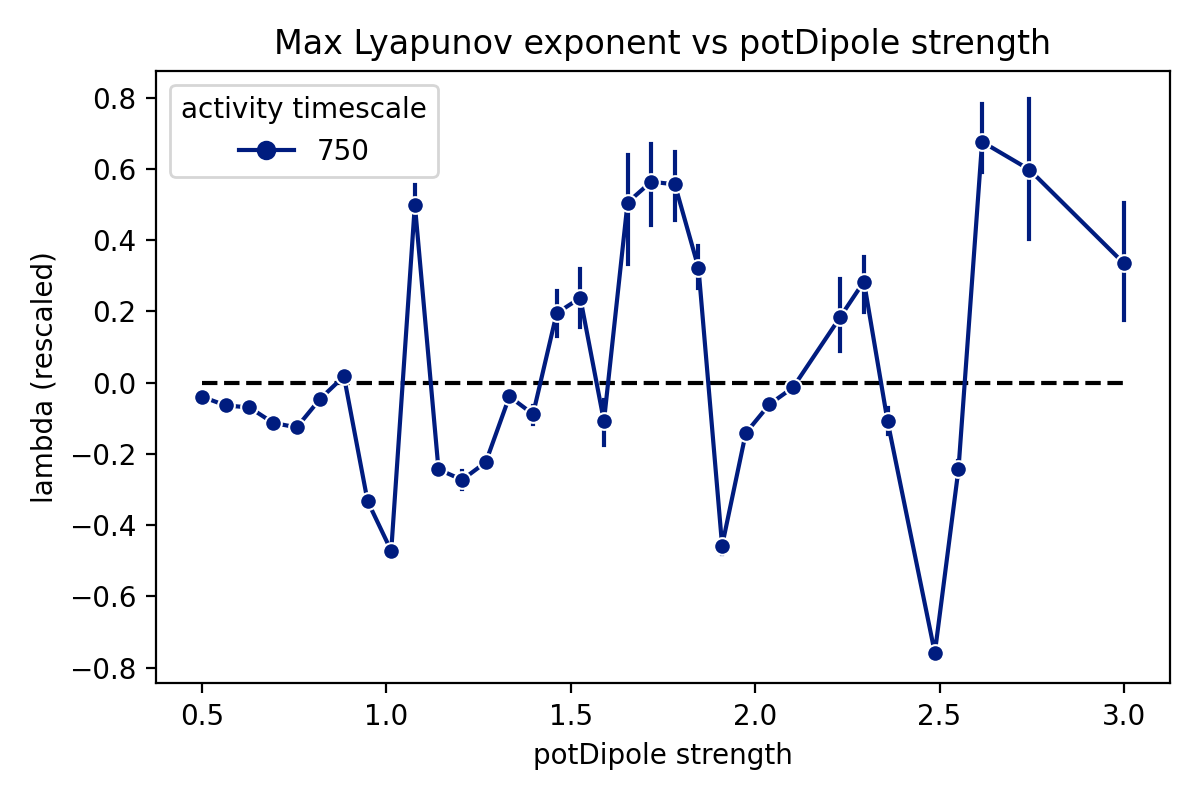

In [2]:
# plt.style.use('default')

processed_data_folder = '/home/deepak/Dropbox/LacryModeling/processed_data'
save_folder = os.path.join(processed_data_folder, 'IC_sensitivity_analysis')

parameter = 'potDipole strength'

file_path = os.path.join(save_folder,'lyapunov_exp_vs_{}.csv'.format(parameter))


if(os.path.exists(file_path)):
    
    df_lyapunov = pd.read_csv(file_path)



# Plot the lyapunov exponent data

import seaborn as sns
%matplotlib notebook


title = 'Max Lyapunov exponent vs {}'.format(parameter)
plt.figure(figsize=(6,4))
sns.lineplot(data = df_lyapunov, x = parameter, y = 'lambda (rescaled)', style = 'activity timescale', 
             hue="activity timescale", err_style = 'bars', markers = True, color = 'r', palette = 'dark')
plt.hlines(y=0, xmin=min(df_lyapunov[parameter]),xmax=max(df_lyapunov[parameter]), linestyle = '--', color = 'k')
plt.title(title)



# plt.savefig(os.path.join(publication_figures, title+'.png'), dpi = 300)
# plt.savefig(os.path.join(publication_figures, title+'.svg'), dpi = 300)

plt.tight_layout()
plt.show()

In [8]:
# Calculate the typical value of the max Lyapunov exponent

lyapunov_mean = np.mean(df_lyapunov['lambda (rescaled)'].loc[df_lyapunov['lambda (rescaled)']>0])

lyapunov_min = np.min(df_lyapunov['lambda (rescaled)'].loc[df_lyapunov['lambda (rescaled)']>0])
lyapunov_max = np.max(df_lyapunov['lambda (rescaled)'].loc[df_lyapunov['lambda (rescaled)']>0])

In [11]:
print(lyapunov_mean)

print(lyapunov_min)
print(lyapunov_max)

0.38957374155691993
0.005706336290150379
1.087462138657607


## Predictability Horizon Plot

<IPython.core.display.Javascript object>


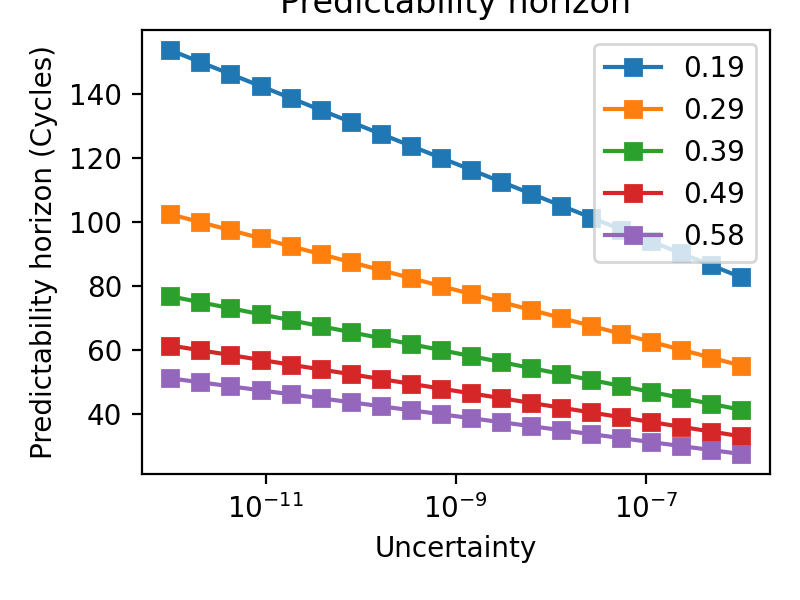

In [25]:
lyapunov_array = np.linspace(0.5*lyapunov_mean, 1.5*lyapunov_mean, 5)

tolerance = 10
delta_0_array = np.logspace(-12, -6, 20)

tau_horizon = np.zeros_like(delta_0_array)


save = True

plt.figure(figsize=(4,3))

title = 'Predictability horizon'

for lyapunov in lyapunov_array:

    tau_horizon = (1/lyapunov)*np.log(tolerance/delta_0_array)

    plt.plot(delta_0_array, tau_horizon, marker = 's', label = np.round(lyapunov,2))
    
    
plt.xlabel('Uncertainty')
plt.ylabel('Predictability horizon (Cycles)')
plt.xscale('log')
plt.tight_layout()
plt.legend()
plt.title(title)
if save:
    plt.savefig(os.path.join(publication_figures, title+'.png'), dpi = 300)
    plt.savefig(os.path.join(publication_figures, title+'.svg'), dpi = 300)
plt.show()